In [3]:
import h5py
import psana
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import  rotate
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit,minimize
import multiprocessing
import os
from functools import partial
import time
import sys
import argparse
from datetime import datetime
import tempfile
import XSpect.XSpect_Analysis
import XSpect.XSpect_Controller
import XSpect.XSpect_Visualization
import XSpect.XSpect_PostProcessing
import XSpect.XSpect_Diagnostics

**2D Scan**

In [4]:
start=time.time()
xas_experiment = XSpect.XSpect_Analysis.spectroscopy_experiment(lcls_run=22, hutch='xcs', experiment_id='xcsx1008722')
xas=XSpect.XSpect_Controller.XASBatchAnalysis()
keys=['epics/ccm_E','epicsUser/ccm_E_setpoint','tt/ttCorr','epics/lxt_ttc', 'enc/lasDelay' , 'ipm5/sum','tt/AMPL','epix_2/ROI_0_sum'] 
names=['ccm','ccm_E_setpoint','time_tool_correction','lxt_ttc'  ,'encoder','ipm', 'time_tool_ampl','epix']
xas.set_key_aliases(keys,names)
xas.add_filter('xray','ipm',100.0)
xas.add_filter('simultaneous','ipm',100.0)
xas.add_filter('simultaneous','time_tool_ampl',0.01)
xas.run_parser(['33']) # 7.5 uJ -0.5 to 2 ps
xas.mintime = -1
xas.maxtime = 1
xas.numpoints = 41
# xas.primary_analysis_parallel_loop(4,xas_experiment)
xas.primary_analysis_loop(xas_experiment)
end=time.time()
print('Time binning: {} ps steps'.format(np.min(np.diff(xas.time_bins))))

Time binning: 0.04999999999999982 ps steps


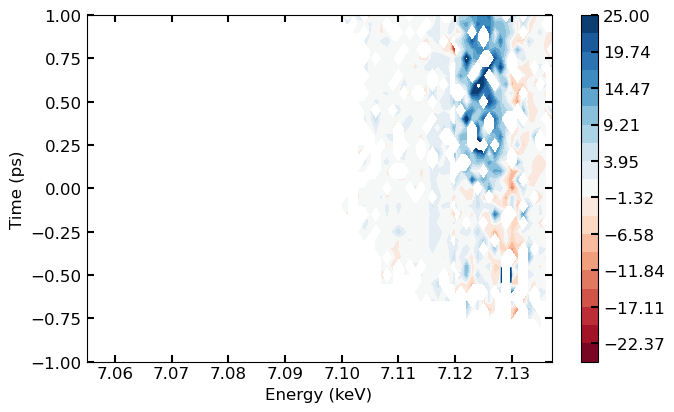

In [17]:
v=XSpect.XSpect_Visualization.XASVisualization()
v.combine_spectra(xas_analysis=xas,
                  xas_laser_key='epix_simultaneous_laser_time_energy_binned',
                  xas_key='epix_xray_not_laser_time_energy_binned',
                  norm_laser_key='ipm_simultaneous_laser_time_energy_binned',
                  norm_key='ipm_xray_not_laser_time_energy_binned')


v.plot_2d_difference_spectrum(xas,vmin=-50,vmax=50)
#plt.axvline(7.1145, color = 'r')

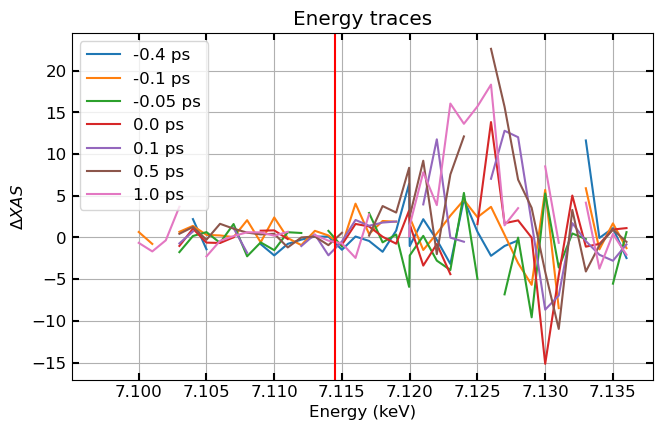

In [9]:
tlist = [-0.4, -0.1, -0.06, -0.02, 0.1, 0.5, 1.5]
# tlist = [-2, 0, 5, 20, 40]
leglist = []

for ii in tlist:
    b = np.min(np.abs(xas.time_bins-ii))
    indx = np.argmin(np.abs(xas.time_bins-ii))
    plt.plot(xas.ccm_bins, xas.difference_spectrum[indx,:])
    leglist.append('{} ps'.format(np.round(xas.time_bins[indx], decimals = 2)))
plt.legend(leglist)
plt.grid()
plt.xlabel('Energy (keV)')
plt.ylabel(r'$\Delta XAS$')
plt.title('Energy traces')
plt.axvline(7.1145, color='r')

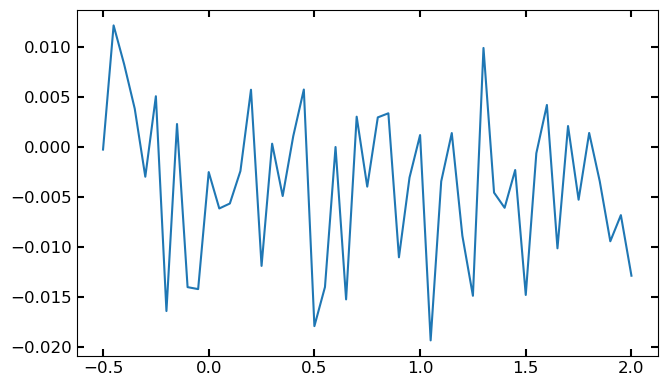

In [432]:
# # en_kin_min, en_kin_max = 7.124, 7.126
# en_kin_min, en_kin_max = 7.117, 7.119

# indx_min = np.argmin(np.abs(xas.ccm_bins - en_kin_min))
# indx_max = np.argmin(np.abs(xas.ccm_bins - en_kin_max))
# kintrace = np.nanmean(diff_svd[:,indx_min:indx_max], axis=1)
# plt.plot(xas.time_bins, kintrace)

# en_kin = 7.1185
en_kin = 7.1145

indx = np.argmin(np.abs(xas.ccm_bins - en_kin))
kintrace = xas.difference_spectrum[:,indx]
plt.plot(xas.time_bins, kintrace)


In [420]:
ana = XSpect.XSpect_PostProcessing.post_analysis()

In [421]:
xas.difference_spectrum.shape

(51, 54)

In [422]:
# np.set_printoptions(threshold=sys.maxsize)
print(xas.difference_spectrum)

[[-6.55713519e-04 -4.59163395e-05  3.97764757e-03 ...  7.34848917e-03
   5.36609479e-03 -7.24319033e-03]
 [ 1.54764448e-03  3.08549894e-03  7.44956868e-03 ... -2.53729070e-02
  -8.23009903e-04 -1.25375780e-02]
 [ 1.48132952e-03  3.89384177e-03  2.72766676e-03 ...  5.18056925e-02
  -1.47341459e-02  4.88107604e-03]
 ...
 [ 3.55457754e-03 -2.75947740e-03 -2.05382413e-03 ... -6.25308149e-02
  -5.46653793e-02 -5.75897670e-02]
 [-3.69409103e-03  2.65321155e-03  1.48315671e-03 ... -9.49814882e-02
  -5.95251502e-02 -4.61738598e-02]
 [-1.51270736e-03 -2.49475751e-03 -3.72746179e-03 ... -1.14526021e-01
  -1.39481150e-01 -3.85604978e-02]]


**SVD**

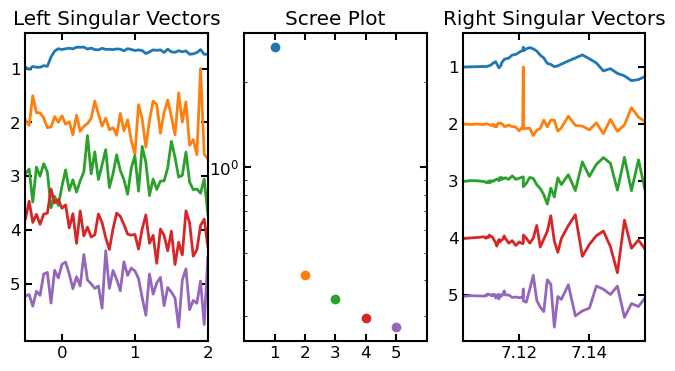

In [424]:
ncomp = 5
diff = np.nan_to_num(xas.difference_spectrum)
ana.svdplot(xas.time_bins, xas.ccm_bins, diff, ncomp)

SVD Reconstruction performed with 5 components


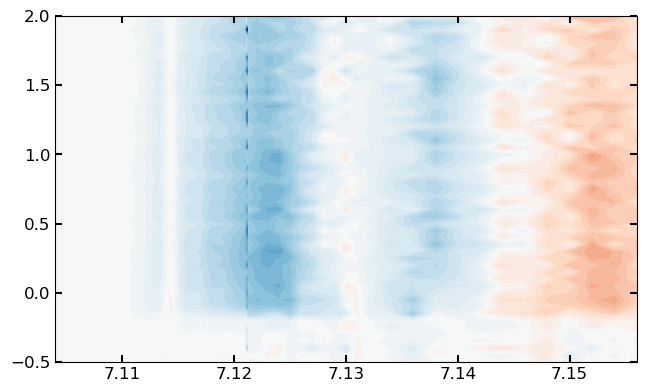

In [425]:
nsvd = 5
diff_svd = ana.svdreconstruct(diff, nsvd)

plotmax = np.max(np.abs(diff_svd))
contlevels = np.linspace(-plotmax, plotmax, 50)
plt.contourf(xas.ccm_bins, xas.time_bins, diff_svd, contlevels, cmap = 'RdBu')

Text(0.5, 1.0, 'SVD reconstructed energy traces')

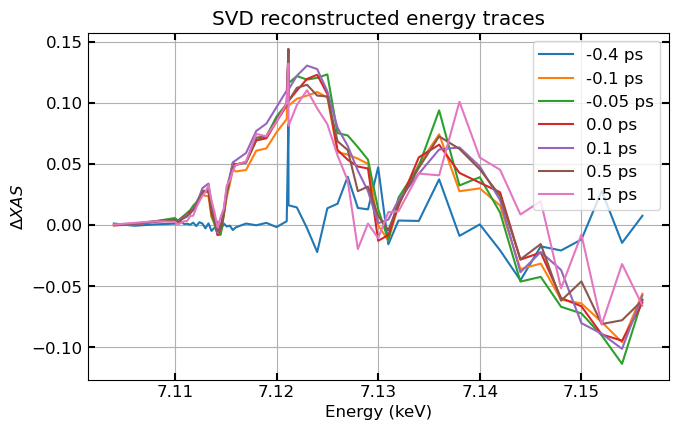

In [426]:
tlist = [-0.4, -0.1, -0.06, -0.02, 0.1, 0.5, 1.5]
# tlist = [-2, 0, 5, 10, 20]
leglist = []

for ii in tlist:
    b = np.min(np.abs(xas.time_bins-ii))
    indx = np.argmin(np.abs(xas.time_bins-ii))
    plt.plot(xas.ccm_bins, diff_svd[indx,:])
    leglist.append('{} ps'.format(np.round(xas.time_bins[indx], decimals = 2)))
plt.legend(leglist)
plt.grid()
plt.xlabel('Energy (keV)')
plt.ylabel(r'$\Delta XAS$')
plt.title('SVD reconstructed energy traces')

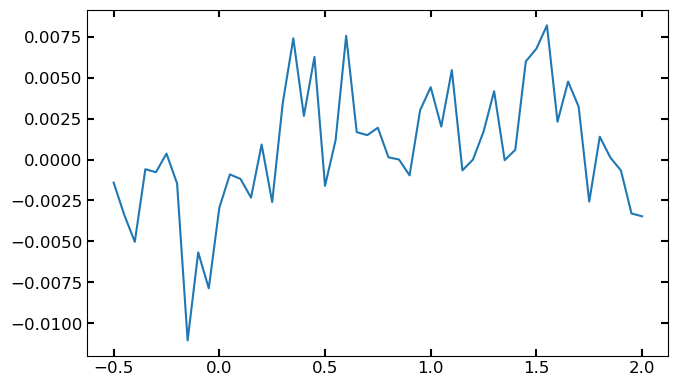

In [427]:
# en_kin_min, en_kin_max = 7.124, 7.126

# indx_min = np.argmin(np.abs(xas.ccm_bins - en_kin_min))
# indx_max = np.argmin(np.abs(xas.ccm_bins - en_kin_max))
# kintrace = np.nanmean(diff_svd[:,indx_min:indx_max], axis=1)
# plt.plot(xas.time_bins, kintrace)

en_kin = 7.118
en_kin = 7.1145

indx = np.argmin(np.abs(xas.ccm_bins - en_kin))
kintrace = diff_svd[:,indx]
plt.plot(xas.time_bins, kintrace)


**Global Kinetic Analysis**

Fit Parameters:
{'k': array([5.79691586, 0.16443394]), 'center': array([-0.15895249]), 'sigma': array([0.04466692]), 'amplitudes': array([], dtype=float64)}

Cost:
0.5306303063258462

tau1: 0.17250552252232776 ps
tau2: 6.08146956266475 ps
IRF center: -0.15895249366303812 ps
IRF FWHM: 0.10518256324937224 ps


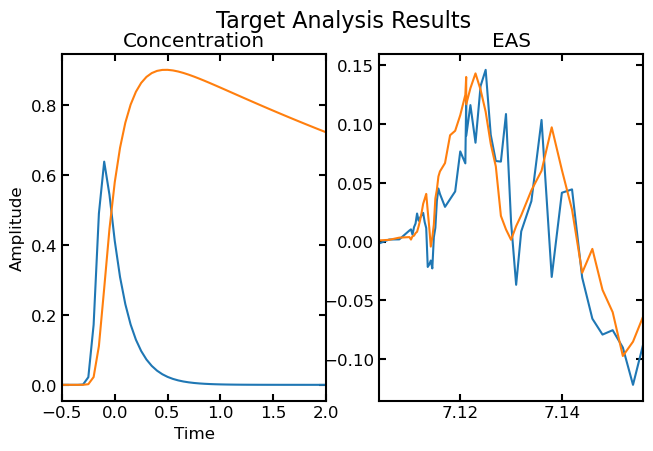

In [428]:
k_guess = [0.2, 0.001]
irf_t0_guess = [0]
irf_sigma_guess = [0.1]
# data2fit = diff_svd
data2fit = np.nan_to_num(xas.difference_spectrum)

K_guess = lambda x:np.array([(-x[0], 0), (x[0], -x[1])]) # sequential
X0_guess = [1,0] # sequential

# K_guess = lambda x:np.array([(-x[0], 0), (0, -x[1])]) # parallel
# X0_guess = [1,1] # parallel

fit, Cfit, Efit = ana.targetanalysis_run(data2fit, xas.time_bins, K_guess, k_guess, irf_t0_guess, irf_sigma_guess, X0_guess, y = xas.ccm_bins)

print('')
print('tau1: {} ps'.format(1/fit.x[0]))
print('tau2: {} ps'.format(1/fit.x[1]))
print('IRF center: {} ps'.format(fit.x[2]))
print('IRF FWHM: {} ps'.format(2*np.sqrt(2*np.log(2))*fit.x[3]))

**Overlay fit w/ Time Trace**

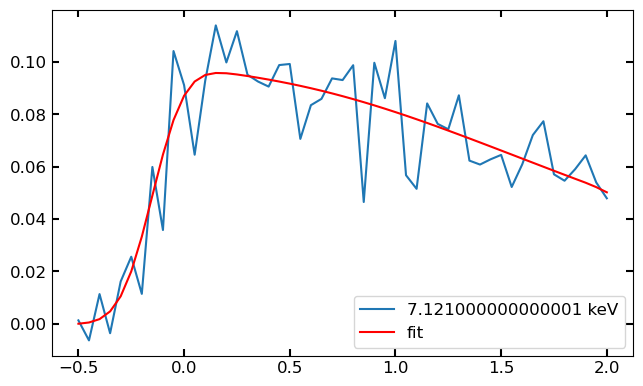

In [401]:
Afit = Cfit@np.transpose(Efit)
Afit.shape

# en_kin_min, en_kin_max = 7.120, 7.122
en_kin = 7.121

# indx_min = np.argmin(np.abs(xas.ccm_bins - en_kin_min))
# indx_max = np.argmin(np.abs(xas.ccm_bins - en_kin_max))
# kintrace_fit = np.nanmean(Afit[:,indx_min:indx_max], axis=1)
# kintrace = np.nanmean(data2fit[:,indx_min:indx_max], axis=1)
indx = np.argmin(np.abs(xas.ccm_bins - en_kin))
kintrace_fit = Afit[:,indx]
kintrace = data2fit[:,indx]
plt.plot(xas.time_bins, kintrace)
plt.plot(xas.time_bins, kintrace_fit, color='r')
# plt.legend(['{} keV'.format((en_kin_min+en_kin_max)/2), 'fit'])
plt.legend(['{} keV'.format(xas.ccm_bins[indx]), 'fit'])

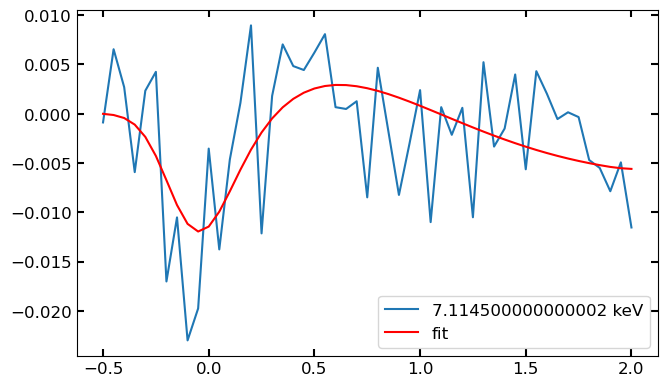

In [402]:
Afit = Cfit@np.transpose(Efit)
Afit.shape

# en_kin = 7.118
en_kin = 7.1145

indx = np.argmin(np.abs(xas.ccm_bins - en_kin))
kintrace_fit = Afit[:,indx]
kintrace = data2fit[:,indx]
plt.plot(xas.time_bins, kintrace)
plt.plot(xas.time_bins, kintrace_fit, color='r')
plt.legend(['{} keV'.format(xas.ccm_bins[indx]), 'fit'])

Fit Parameters:
{'k': array([0.15132422]), 'center': array([-0.16054242]), 'sigma': array([0.05295148]), 'amplitudes': array([], dtype=float64)}

Cost:
2.0515788680372227

tau1: 6.608327469270773 ps
IRF center: -0.16054242393681778 ps
IRF FWHM: 0.12469121346702511 ps


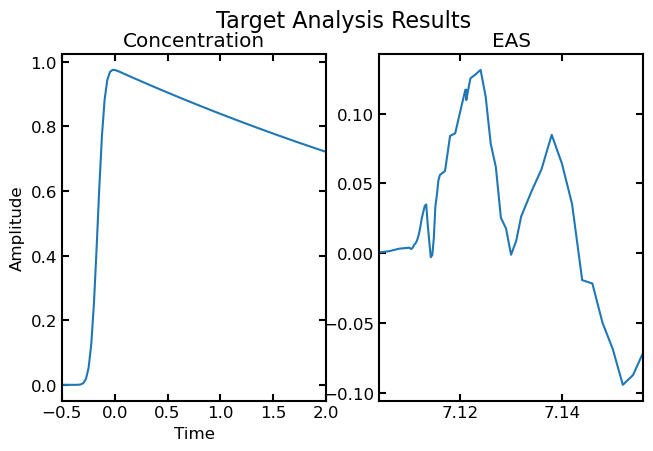

In [153]:
k_guess = [0.001]
irf_t0_guess = [0]
irf_sigma_guess = [0.1]
# data2fit = diff_svd
data2fit = np.nan_to_num(xas.difference_spectrum)

K_guess = lambda x:np.array([-x[0]])
X0_guess = [1]

fit, Cfit, Efit = ana.targetanalysis_run(data2fit, xas.time_bins, K_guess, k_guess, irf_t0_guess, irf_sigma_guess, X0_guess, y = xas.ccm_bins)
print('')
print('tau1: {} ps'.format(1/fit.x[0]))
print('IRF center: {} ps'.format(fit.x[1]))
print('IRF FWHM: {} ps'.format(2*np.sqrt(2*np.log(2))*fit.x[2]))

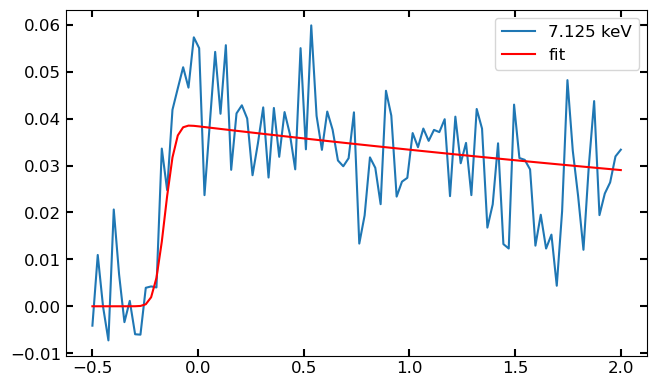

In [322]:
Afit = Cfit@np.transpose(Efit)
Afit.shape

en_kin_min, en_kin_max = 7.124, 7.126

indx_min = np.argmin(np.abs(xas.ccm_bins - en_kin_min))
indx_max = np.argmin(np.abs(xas.ccm_bins - en_kin_max))
kintrace_fit = np.nanmean(Afit[:,indx_min:indx_max], axis=1)
kintrace = np.nanmean(data2fit[:,indx_min:indx_max], axis=1)
plt.plot(xas.time_bins, kintrace)
plt.plot(xas.time_bins, kintrace_fit, color='r')
plt.legend(['{} keV'.format((en_kin_min+en_kin_max)/2), 'fit'])

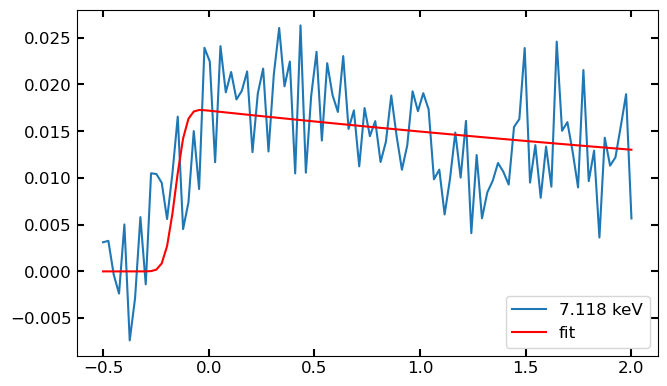

In [323]:
Afit = Cfit@np.transpose(Efit)
Afit.shape

en_kin = 7.118

indx = np.argmin(np.abs(xas.ccm_bins - en_kin))
kintrace_fit = Afit[:,indx]
kintrace = data2fit[:,indx]
plt.plot(xas.time_bins, kintrace)
plt.plot(xas.time_bins, kintrace_fit, color='r')
plt.legend(['{} keV'.format(en_kin), 'fit'])

<font size=5>XAS Analysis and Visualization Test</font>

**1D XAS**

In [2]:
start=time.time()
xas_experiment = XSpect.XSpect_Analysis.spectroscopy_experiment(lcls_run=22, hutch='xcs', experiment_id='xcsl1030422')
xas=XSpect.XSpect_Controller.XASBatchAnalysis_1D_ccm()
keys=['epics/ccm_E','epicsUser/ccm_E_setpoint','tt/ttCorr','epics/lxt_ttc', 'enc/lasDelay' , 'ipm4/sum','tt/AMPL','epix_2/ROI_0_sum'] 
names=['ccm','ccm_E_setpoint','time_tool_correction','lxt_ttc'  ,'encoder','ipm', 'time_tool_ampl','epix']
xas.set_key_aliases(keys,names)
xas.add_filter('xray','ipm',500.0)
xas.add_filter('simultaneous','ipm',500.0)
# xas.add_filter('simultaneous','time_tool_ampl',0.01)
xas.run_parser(['255'])
# xas.primary_analysis_parallel_loop(4,xas_experiment)
xas.primary_analysis_loop(xas_experiment)
end=time.time()

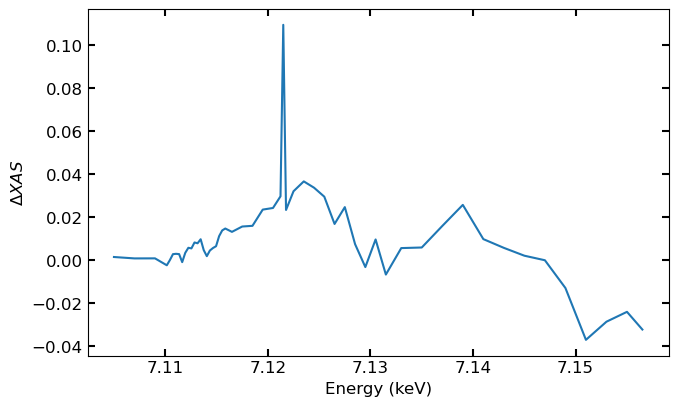

In [3]:
v=XSpect.XSpect_Visualization.XASVisualization()
v.combine_spectra(xas_analysis=xas,
                  xas_laser_key='epix_simultaneous_laser_energy_binned',
                  xas_key='epix_xray_not_laser_energy_binned',
                  norm_laser_key='ipm_simultaneous_laser_energy_binned',
                  norm_key='ipm_xray_not_laser_energy_binned')
v.plot_1d_difference_spectrum(xas)

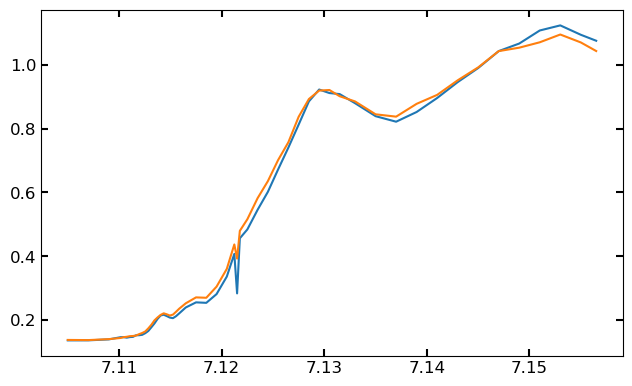

In [12]:
energy = xas.analyzed_runs[0].ccm_bins[:]
lasoff = xas.analyzed_runs[0].epix_xray_not_laser_energy_binned[:]
lason = xas.analyzed_runs[0].epix_simultaneous_laser_energy_binned[:]
ipmoff = xas.analyzed_runs[0].ipm_xray_not_laser_energy_binned[:]
ipmon = xas.analyzed_runs[0].ipm_simultaneous_laser_energy_binned[:]
# plt.plot(energy, lasoff)
# plt.plot(energy, lason)
# plt.plot(energy, ipmoff)
# plt.plot(energy, ipmon)
plt.plot(energy, lasoff/ipmoff)
plt.plot(energy, lason/ipmon)

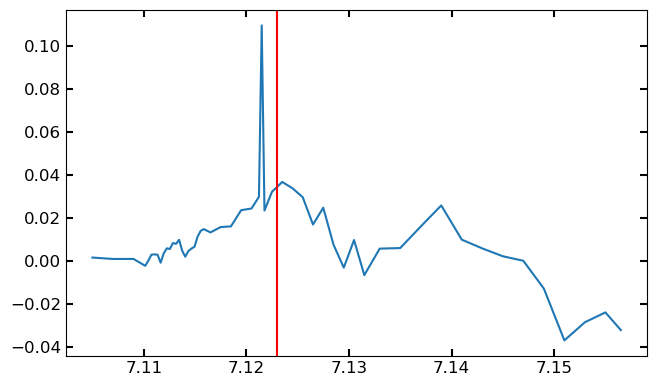

In [14]:
diff = (lason/ipmon) - (lasoff/ipmoff)
plt.plot(energy, diff)
plt.axvline(7.123, color = 'r')

**1D Time Scan**

In [4]:
start=time.time()
xas_experiment = XSpect.XSpect_Analysis.spectroscopy_experiment(lcls_run=22, hutch='xcs', experiment_id='xcsl1030422')
xas=XSpect.XSpect_Controller.XASBatchAnalysis_1D_time()
keys=['epics/ccm_E','epicsUser/ccm_E_setpoint','tt/ttCorr','epics/lxt_ttc', 'enc/lasDelay' , 'ipm4/sum','tt/AMPL','epix_2/ROI_0_sum'] 
names=['ccm','ccm_E_setpoint','time_tool_correction','lxt_ttc'  ,'encoder','ipm', 'time_tool_ampl','epix']
xas.set_key_aliases(keys,names)
xas.add_filter('xray','ipm',500.0)
xas.add_filter('simultaneous','ipm',500.0)
xas.add_filter('simultaneous','time_tool_ampl',0.01)
xas.run_parser(['211-213'])
xas.mintime = -1
xas.maxtime = 1
xas.numpoints = 20
# xas.primary_analysis_parallel_loop(4,xas_experiment)
xas.primary_analysis_loop(xas_experiment)
end=time.time()

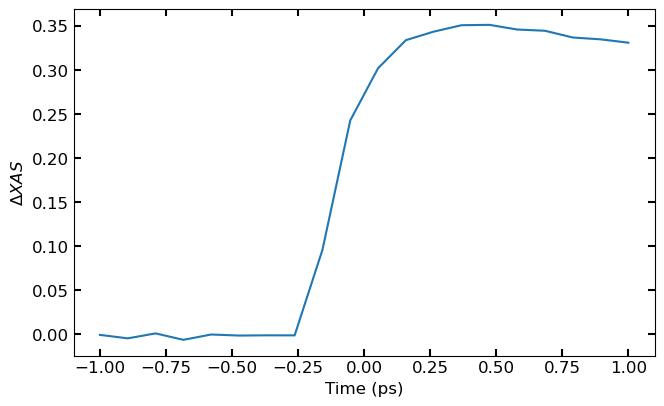

In [5]:
v=XSpect.XSpect_Visualization.XASVisualization()
v.combine_spectra(xas_analysis=xas,
                  xas_laser_key='epix_simultaneous_laser_time_binned',
                  xas_key='epix_xray_not_laser_time_binned',
                  norm_laser_key='ipm_simultaneous_laser_time_binned',
                  norm_key='ipm_xray_not_laser_time_binned')
v.plot_1d_difference_time(xas)